# Redes Neurais Recorrentes em series temporais: Comparação entre LSTM e GRU com dados climáticos de São Luís (MA)

(Notebook construído por Adrielson F. Justino)

## Importação das principais bibliotecas:

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense # Dropout, Bidirectional
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Visualization imports
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Carregando dados

In [2]:
# Lendo arquivo CSV
# filename = "/kaggle/input/diarios-2019-a-2023/diarios_2019_20233.csv"
filename = "/kaggle/input/diarios-2013-2023/diarios_2013_2023_4.csv"
df = pd.read_csv(filename)

## Sobre o dataset
Nessa primeira parte, é carregado o _dataset_ na estrutura de dados que utilizaremos, que será o [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

* Foram coletados dados climáticos da Estação A203 - SÃO LUÍS (MA).
* Os dados foram coletados no site do Instituto Nacional de Meteriologia (INMET) - https://bdmep.inmet.gov.br/

O _dataset_ possui as seguintes colunas (total de 11 colunas):

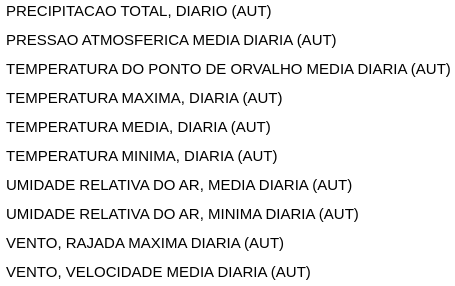

### Dessas colunas, a nossa coluna alvo será TEMPERATURA MÁXIMA (**temp_max**).

In [53]:
# Quantidade de linhas e colunas do dataset, respectivamente
print("\ndataset:= ", df.shape)


dataset:=  (3979, 10)


## Explorando o dataset

- **[head](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html)**: mostra as primeiras _n_ linhas do nosso _dataset_. Por padrão serão as 5 primeiras linhas.
- **[info](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html)**: imprime informações sobre o nosso _DataFrame_, incluindo o tipo de índice, os tipos de coluna, valores não nulos e uso de memória.

- **[describe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html)**: mostra estatísticas descritivas sobre as colunas do nosso _DataFrame_, como: a tendência central, a dispersão e a forma da distribuição de um conjunto de dados.

In [4]:
df.head()

,data,precipitacao_total,pressao_atmosfera,temp_p_orvalho,temp_max,temp_med,temp_min,umidade_med,umidade_rel,vento_rajada_max,vento_vel_med
0,01/01/2013,NaN,"1004,4","24,1375","32,4","27,875","25,5","80,916667",57.0,"10,2","2,020833"
1,02/01/2013,NaN,"1004,383333","23,979167","30,4","26,679167","23,3","85,583333",72.0,"9,7","1,925"
2,03/01/2013,NaN,"1005,854167","23,779167","30,7","26,475","22,8","85,833333",67.0,"10,1","2,104167"
3,04/01/2013,NaN,"1007,575","24,208333","30,1","25,55","23,7","92,791667",73.0,"10,9","1,4125"
4,05/01/2013,NaN,"1007,241667","25,4","31,5","26,791667","23,8","92,583333",73.0,"9,3","1,8375"


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3979 entries, 0 to 3978
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   data                3979 non-null   object 
 1   precipitacao_total  2748 non-null   object 
 2   pressao_atmosfera   3803 non-null   object 
 3   temp_p_orvalho      3762 non-null   object 
 4   temp_max            3825 non-null   object 
 5   temp_med            3780 non-null   object 
 6   temp_min            3829 non-null   object 
 7   umidade_med         3830 non-null   object 
 8   umidade_rel         3890 non-null   float64
 9   vento_rajada_max    3946 non-null   object 
 10  vento_vel_med       3803 non-null   object 
dtypes: float64(1), object(10)
memory usage: 342.1+ KB


In [6]:
cols_to_convert = ['precipitacao_total', 'pressao_atmosfera', 'temp_p_orvalho', 'temp_max', 'temp_med', 'temp_min', 'umidade_med', 'vento_rajada_max', 'vento_vel_med']

# Substituição de vírgulas por pontos e conversão para float64
for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col].str.replace(',', '.'), errors='coerce')
    
print(df.dtypes)

data                   object
precipitacao_total    float64
pressao_atmosfera     float64
temp_p_orvalho        float64
temp_max              float64
temp_med              float64
temp_min              float64
umidade_med           float64
umidade_rel           float64
vento_rajada_max      float64
vento_vel_med         float64
dtype: object


In [7]:
df.describe()

,precipitacao_total,pressao_atmosfera,temp_p_orvalho,temp_max,temp_med,temp_min,umidade_med,umidade_rel,vento_rajada_max,vento_vel_med
count,2748.000000,3803.000000,3762.000000,3825.000000,3780.000000,3829.000000,3830.000000,3890.000000,3946.000000,3803.000000
mean,5.116157,1005.673761,23.225622,30.983320,26.810109,24.338548,81.654281,61.064267,9.153573,1.792648
std,13.208198,1.487465,0.788714,1.488967,0.987904,1.089852,6.538840,8.497575,1.913193,0.768991
min,0.000000,1000.529167,20.162500,24.400000,23.275000,20.600000,65.666667,30.000000,0.000000,0.000000
25%,0.000000,1004.637500,22.662500,30.300000,26.200000,23.600000,75.916667,55.000000,8.000000,1.187500
50%,0.000000,1005.604167,23.220833,31.200000,26.912500,24.300000,81.833333,60.000000,9.200000,1.695833
75%,3.400000,1006.681250,23.762994,32.000000,27.558333,25.200000,87.041667,66.000000,10.400000,2.445138
max,222.400000,1010.741667,26.800000,34.900000,29.183333,27.100000,99.785714,97.000000,18.400000,3.783333


# Limpando, preparando e manipulando os dados
Nessa etapa, é realizado o processo de limpeza, preparação e manipulação dos dados do nosso _DataFrame_.

## Valores faltantes
Em várias colunas há a presença de `null`, que representa valores faltantes.

In [8]:
print(df.isnull().sum())

data                     0
precipitacao_total    1231
pressao_atmosfera      176
temp_p_orvalho         217
temp_max               154
temp_med               199
temp_min               150
umidade_med            149
umidade_rel             89
vento_rajada_max        33
vento_vel_med          176
dtype: int64


In [9]:
df = df.drop(columns=['precipitacao_total'])

In [10]:
numeric_cols = [
            'data',
            'pressao_atmosfera', 
            'temp_p_orvalho', 
            'temp_max', 
            'temp_med', 
            'temp_min', 
            'umidade_med', 
            'umidade_rel', 
            'vento_rajada_max', 
            'vento_vel_med'
]

In [11]:
# Quantidade de linhas antes
df_shape = df.shape
df_shape

(3979, 10)

In [13]:
# Removendo as colunas com valor igual a zero
df2 = df
for col in numeric_cols:
  df2 = df2[df2[col].notna()]

In [14]:
# Quantidade de linhas depois
df2.shape

(3743, 10)

## Criando novas 
Como as colunas **date** e **hour** são de objetos, elas não nos servem para a criação do modelo posteriormente. Sendo assim, vamos criar as seguintes colunas a partir delas:
- **day**: o dia do registro;
- **month**: o mês do registro;
- **year**: o ano do registro;
- **week**: a semana do ano do registro;
- **day_week**: o dia da semana do registro;
- **hour**: a hora do registro.

In [15]:
# Ajustando data doformato dd/mm/aaaa para aaaa/mm/dd
df2['data'] = pd.to_datetime(df2['data'], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')

In [16]:
df2['data'] = pd.to_datetime(df2['data'], format='%Y-%m-%d')

In [17]:
df2['data']

0      2013-01-01
1      2013-01-02
2      2013-01-03
3      2013-01-04
4      2013-01-05
          ...    
3973   2023-11-18
3974   2023-11-19
3975   2023-11-20
3976   2023-11-21
3977   2023-11-22
Name: data, Length: 3743, dtype: datetime64[ns]

In [18]:
print(df2['data'].min(), df2['data'].max())

2013-01-01 00:00:00 2023-11-22 00:00:00


In [19]:
# Criando as novas colunas
df2['dia'] = df2['data'].dt.day
df2['mes'] = df2['data'].dt.month
df2['ano'] = df2['data'].dt.year

In [21]:
df2['ano'].value_counts()

ano
2016    366
2020    366
2021    365
2022    365
2015    364
2018    359
2014    333
2023    325
2019    304
2013    299
2017    297
Name: count, dtype: int64

In [23]:
# df2.index = pd.to_datetime(df2.index, unit='D', origin='2019-01-01')
df2.index = pd.to_datetime(df2.index, unit='D', origin='2013-01-01')

# primeiros 5 valores do índice após a conversão
print(df2.index[:5])

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05'],
              dtype='datetime64[ns]', freq=None)


In [24]:
# Dividir os dados em conjuntos de treino e teste
# train_data = df2[df2.index < '2023-08-01'] 
# test_data = df2[df2.index >= '2023-08-01']  
train_data = df2[df2.index < '2023-01-01'] 
test_data = df2[df2.index >= '2023-01-01']  

print(len(train_data), '---', len(test_data))

3418 --- 325


## Selecionando coluna alvo (temperatura máxima) e quaisquer outros atributos relevantes para usar como entrada

In [25]:

features = ['pressao_atmosfera', 'temp_p_orvalho', 'temp_max', 'temp_med', 'temp_min', 'umidade_med', 'umidade_rel', 'vento_rajada_max', 'vento_vel_med']
target = ['temp_max']

train_features = train_data[features]
train_target = train_data[target]

test_features = test_data[features]
test_target = test_data[target]

In [26]:
test_target

,temp_max
2023-01-01,31.0
2023-01-02,30.3
2023-01-03,31.2
2023-01-04,32.0
2023-01-05,31.0
...,...
2023-11-18,32.7
2023-11-19,32.8
2023-11-20,31.8
2023-11-21,32.8


## Normalização dos dados de entrada (atributos) e saída (target)

In [27]:
scaler = MinMaxScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

target_scaler = MinMaxScaler()
train_target_scaled = target_scaler.fit_transform(train_target)
test_target_scaled = target_scaler.transform(test_target)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasatt

## Preparar os dados para a modelagem em séries temporais

* Foi definido uma função para criar sequências temporais para os modelos.
* Serão considerados **30 passos** temporais consecutivos como entrada para prever o próximo valor na série temporal

In [28]:
def create_sequences(features, target, time_steps=1):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:(i + time_steps)])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 30  # Tamanho das sequências temporais

# Sequências temporais para treino e teste
X_train, y_train = create_sequences(train_features_scaled, train_target_scaled, time_steps)
X_test, y_test = create_sequences(test_features_scaled, test_target_scaled, time_steps)

# Ajustando as dimensões dos dados para a entrada dos modelos
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], len(features))
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], len(features))

## Definição modelo LSTM

In [29]:
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], len(features))))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(units=1))

O modelo LSTM foi definido utilizando a API Sequential do Keras.
* **Camada LSTM com 50 neurônios**
    
    *A camada tem como entrada um tensor tridimensional com o número de passos temporais e o número de atributos.*
    
* **Camada LSTM com 50 neurônios**
    
    *Esta camada retorna apenas o estado oculto final.*
    
* **Camada DENSA com 1 neurônio**
    
    *Gera a saída final, a previsão da temperatura máxima.*

#### Compilar e treinar o modelo LSTM

In [30]:
model_lstm.compile(optimizer='adam', loss='mean_squared_error', metrics = 'mae')
model_lstm.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
106/106 [==============================] - 10s 7ms/step - loss: 0.0234 - mae: 0.1096
Epoch 2/20
106/106 [==============================] - 1s 7ms/step - loss: 0.0137 - mae: 0.0876
Epoch 3/20
106/106 [==============================] - 1s 6ms/step - loss: 0.0128 - mae: 0.0840
Epoch 4/20
106/106 [==============================] - 1s 6ms/step - loss: 0.0122 - mae: 0.0820
Epoch 5/20
106/106 [==============================] - 1s 6ms/step - loss: 0.0122 - mae: 0.0812
Epoch 6/20
106/106 [==============================] - 1s 8ms/step - loss: 0.0118 - mae: 0.0805
Epoch 7/20
106/106 [==============================] - 1s 7ms/step - loss: 0.0115 - mae: 0.0786
Epoch 8/20
106/106 [==============================] - 1s 6ms/step - loss: 0.0116 - mae: 0.0797
Epoch 9/20
106/106 [==============================] - 1s 6ms/step - loss: 0.0112 - mae: 0.0777
Epoch 10/20
106/106 [==============================] - 1s 6ms/step - loss: 0.0114 - mae: 0.0798
Epoch 11/20
106/106 [===========================

## Definição do modelo GRU


* O modelo GRU é definido da mesma forma, mas utiliza camadas GRU.

In [31]:
model_gru = Sequential()
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], len(features))))
model_gru.add(GRU(units=50))
model_gru.add(Dense(units=1))

#### Compilar e treinar o modelo GRU

In [32]:
model_gru.compile(optimizer='adam', loss='mean_squared_error', metrics = 'mae')
model_gru.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
106/106 [==============================] - 4s 6ms/step - loss: 0.0309 - mae: 0.1218
Epoch 2/20
106/106 [==============================] - 1s 6ms/step - loss: 0.0119 - mae: 0.0813
Epoch 3/20
106/106 [==============================] - 1s 6ms/step - loss: 0.0111 - mae: 0.0780
Epoch 4/20
106/106 [==============================] - 1s 6ms/step - loss: 0.0108 - mae: 0.0763
Epoch 5/20
106/106 [==============================] - 1s 6ms/step - loss: 0.0108 - mae: 0.0769
Epoch 6/20
106/106 [==============================] - 1s 6ms/step - loss: 0.0108 - mae: 0.0767
Epoch 7/20
106/106 [==============================] - 1s 6ms/step - loss: 0.0111 - mae: 0.0785
Epoch 8/20
106/106 [==============================] - 1s 6ms/step - loss: 0.0107 - mae: 0.0762
Epoch 9/20
106/106 [==============================] - 1s 6ms/step - loss: 0.0105 - mae: 0.0753
Epoch 10/20
106/106 [==============================] - 1s 6ms/step - loss: 0.0108 - mae: 0.0762
Epoch 11/20
106/106 [============================

## Prever os dados de treino e teste usando os modelos LSTM e GRU

In [33]:
predicted_lstm_train = model_lstm.predict(X_train)
predicted_gru_train = model_gru.predict(X_train)

106/106 [==============================] - 1s 3ms/step


In [34]:
predicted_lstm = model_lstm.predict(X_test)
predicted_gru = model_gru.predict(X_test)

10/10 [==============================] - 0s 3ms/step


## Imprimindo os resultados dos dados de treino e teste

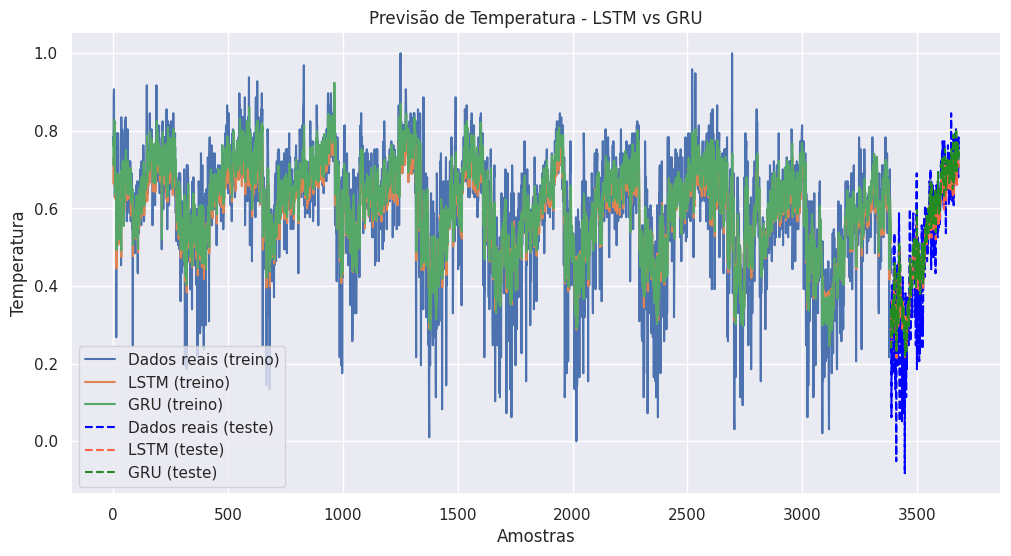

In [35]:
plt.figure(figsize=(12, 6))

# Dados de treino
plt.plot(y_train, label='Dados reais (treino)')
plt.plot(predicted_lstm_train, label='LSTM (treino)',)
plt.plot(predicted_gru_train, label='GRU (treino)',)

# Dados de teste
offset = len(y_train)
plt.plot(range(offset, offset + len(y_test)), y_test, label='Dados reais (teste)', color='blue', linestyle='dashed')
plt.plot(range(offset, offset + len(predicted_lstm)), predicted_lstm, label='LSTM (teste)', color='tomato', linestyle='dashed')
plt.plot(range(offset, offset + len(predicted_gru)), predicted_gru, label='GRU (teste)', color='forestgreen', linestyle='dashed') #color='green'

plt.title('Previsão de Temperatura - LSTM vs GRU')
plt.xlabel('Amostras')
plt.ylabel('Temperatura')
plt.legend()
plt.show()


In [36]:
# Revertendo a escala das previsões para temperatura
predicted_lstm_train = target_scaler.inverse_transform(predicted_lstm_train)
predicted_gru_train = target_scaler.inverse_transform(predicted_gru_train)
y_train = target_scaler.inverse_transform(y_train)

### Treino

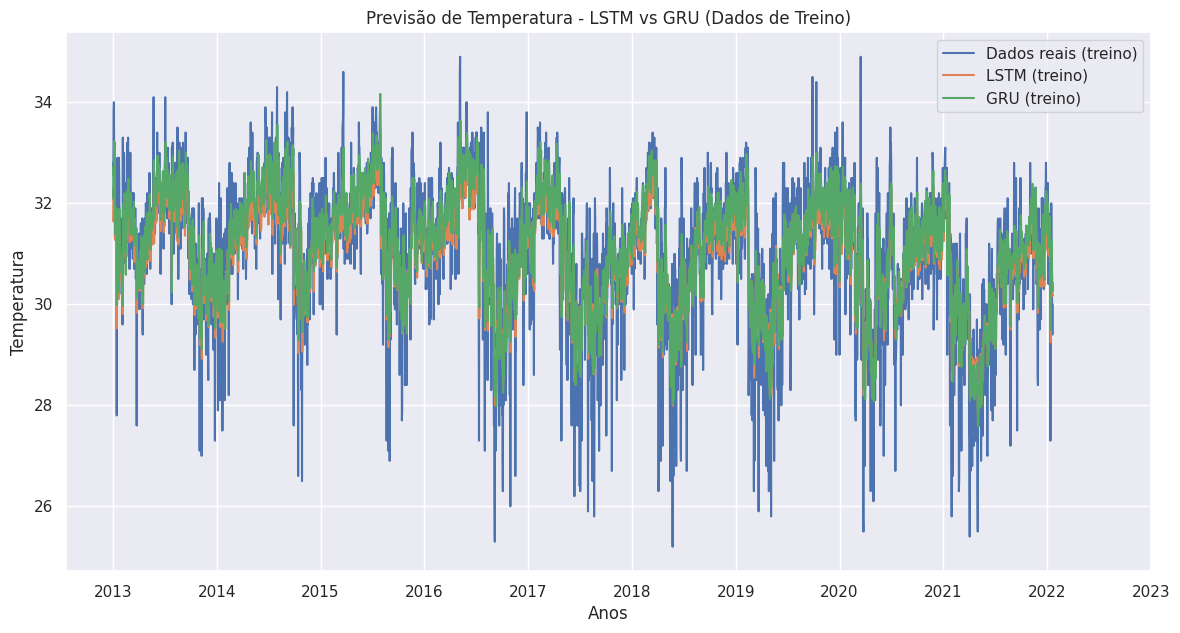

In [38]:
years = df2.index.year.unique()
indices_years = np.linspace(0, len(df2) - 1, len(years)).astype(int)

labels_x = [years[i] for i in range(len(years))]

plt.figure(figsize=(14, 7))
plt.plot(y_train, label='Dados reais (treino)')
plt.plot(predicted_lstm_train, label='LSTM (treino)')
plt.plot(predicted_gru_train, label='GRU (treino)')
plt.title('Previsão de Temperatura - LSTM vs GRU (Dados de Treino)')
plt.xlabel('Anos')
plt.ylabel('Temperatura')
plt.xticks(indices_years, labels_x)
plt.legend()
plt.show()


### Teste

In [39]:
# Revertendo a escala das previsões para temperatura
predicted_lstm = target_scaler.inverse_transform(predicted_lstm)
predicted_gru = target_scaler.inverse_transform(predicted_gru)
y_test = target_scaler.inverse_transform(y_test)

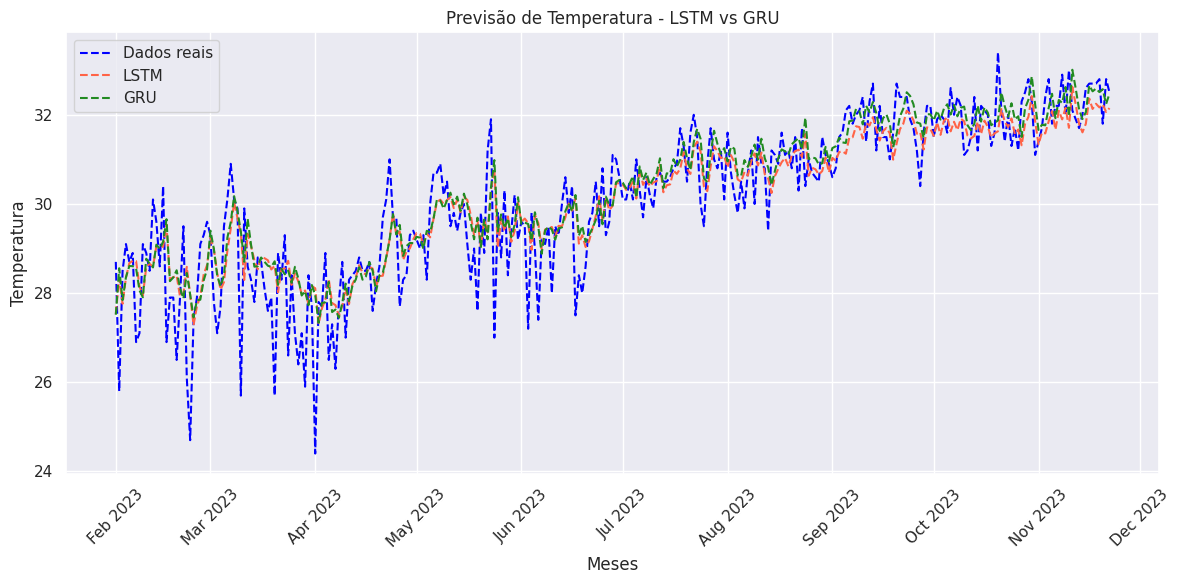

In [41]:
indices_months = np.arange(len(y_test))  
dates = df2.index[-len(y_test):]  

plt.figure(figsize=(12, 6))
plt.plot(dates, y_test, label='Dados reais', color = 'blue',linestyle='dashed')
plt.plot(dates, predicted_lstm, label='LSTM',color = 'tomato', linestyle='dashed')
plt.plot(dates, predicted_gru, label='GRU', color = 'forestgreen', linestyle='dashed')
plt.title('Previsão de Temperatura - LSTM vs GRU')
plt.xlabel('Meses')
plt.ylabel('Temperatura')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Calculando o Erro Quadrado Médio (MSE) dos modelos LSTM e GRU

In [42]:
mse_lstm_train = mean_squared_error(y_train, predicted_lstm_train)
mse_gru_train = mean_squared_error(y_train, predicted_gru_train)

mse_lstm_test = mean_squared_error(y_test, predicted_lstm)
mse_gru_test = mean_squared_error(y_test, predicted_gru)

print(f"MSE para LSTM (treino): {mse_lstm_train}")
print(f"MSE para GRU (treino): {mse_gru_train}")
print(f"MSE para LSTM (teste): {mse_lstm_test}")
print(f"MSE para GRU (teste): {mse_gru_test}")

MSE para LSTM (treino): 0.9781938111060868
MSE para GRU (treino): 0.9513535316616097
MSE para LSTM (teste): 0.883125417779224
MSE para GRU (teste): 0.8911948928099779


Podemos notar que o **modelo LSTM** tem um **MSE** ligeiramente **menor (0.8831)** em comparação com o modelo GRU (0.8912). 

Com base nesse métrica nos dados de teste, sugere-se que o modelo LSTM é ligeiramente melhor do que o modelo GRU na previsão da temperatura máxima.

## Calculando o Erro Absoluto Médio (MAE) dos modelos LSTM e GRU

In [44]:
from sklearn.metrics import mean_absolute_error

In [46]:
mae_lstm_train = mean_absolute_error(y_train, predicted_lstm_train)
mae_gru_train = mean_absolute_error(y_train, predicted_gru_train)

mae_lstm_test = mean_absolute_error(y_test, predicted_lstm)
mae_gru_test = mean_absolute_error(y_test, predicted_gru)

print(f"MAE para LSTM (treino): {mae_lstm_train}")
print(f"MAE para GRU (treino): {mae_gru_train}")
print(f"MAE para LSTM (teste): {mae_lstm_test}")
print(f"MAE para GRU (teste): {mae_gru_test}")

MAE para LSTM (treino): 0.7318667734950045
MAE para GRU (treino): 0.7118564087778788
MAE para LSTM (teste): 0.6845282926397811
MAE para GRU (teste): 0.6823416784254169


Podemos notar que o modelo **GRU** possui um MAE ligeiramente menor (0.6823) em comparação com o modelo LSTM (0.6845). 

Com base nessa métrica nos dados de teste, sugere-se que o modelo GRU é ligeiramente melhor do que o modelo LSTM na previsão da temperatura máxima.